In [55]:
# import libs
import boto3
import json
from PIL import Image
import io

In [56]:
client = boto3.client("lambda")

s3 = boto3.client("s3")

In [57]:
def fetch_image(bucket: str, key: str) -> Image:
    response = s3.get_object(Bucket=bucket, Key=key)
    image_data = response["Body"].read()
    image = Image.open(io.BytesIO(image_data))
    return image

def combine_images_horizontally(images):
    # すべての画像の幅と高さを計算
    total_width = sum(image.width for image in images)
    max_height = max(image.height for image in images)

    # 新しい画像のキャンバスを作成
    new_image = Image.new('RGB', (total_width, max_height))

    # 各画像を新しい画像に貼り付け
    x_offset = 0
    for image in images:
        new_image.paste(image, (x_offset, 0))
        x_offset += image.width

    # 最終的な画像を表示
    new_image.show()


def invoke_lambda(payload:dict):
    response = client.invoke(
        FunctionName="aska-api-dev-MatchingCalculateHandler",
        InvocationType="RequestResponse",
        LogType="Tail",
        Payload=bytes(json.dumps(payload).encode()),
    )
    print(response["Payload"].read().decode("utf-8"))

def main(payload:dict):
    id,page = (payload["body"]["before"]["image_object_key"]).split('/')

    bucket_name = payload["body"]["bucket_name"]
    before_image_key = payload["body"]["before"]["image_object_key"]
    after_image_key = payload["body"]["after"]["image_object_key"]

    before_image = fetch_image(bucket_name,before_image_key)
    after_image = fetch_image(bucket_name,after_image_key)
    invoke_lambda(payload)
    result_image = fetch_image("aska-tmp-dir",f"{id}/diff_{page}")
    combine_images_horizontally([before_image,after_image,result_image])



In [58]:
# edit here

payload = {
    "body": {
        "bucket_name": "aska-image-bucket-dev",
        "before": {"json_object_key":"K16611_before/10.json","image_object_key":"K16611_before/10.png"},
        "after": {"json_object_key":"K16611_after/9.json","image_object_key":"K16611_after/9.png"},
        "params" : {
            "match_threshold" : 0.85,
            "threshold" : 220,
            "eps" : 20,
            "min_samples" : 50,
        },
        "is_dev":True
    }
}


{"errorMessage": "the JSON object must be str, bytes or bytearray, not dict", "errorType": "TypeError", "requestId": "22f85f5c-2571-42c6-9074-c800f18931fe", "stackTrace": ["  File \"/usr/local/lib/python3.11/site-packages/aws_lambda_powertools/middleware_factory/factory.py\", line 133, in wrapper\n    response = middleware()\n", "  File \"/usr/local/lib/python3.11/site-packages/aws_lambda_powertools/utilities/data_classes/event_source.py\", line 39, in event_source\n    return handler(data_class(event), context)\n", "  File \"/usr/local/lib/python3.11/site-packages/aws_lambda_powertools/logging/logger.py\", line 449, in decorate\n    return lambda_handler(event, context, *args, **kwargs)\n", "  File \"/app/app.py\", line 56, in lambda_handler\n    key_list = listup_object_keys(bucket_name)\n", "  File \"/app/app.py\", line 39, in listup_object_keys\n    response = json.loads(response)\n", "  File \"/usr/local/lib/python3.11/json/__init__.py\", line 339, in loads\n    raise TypeError(f'

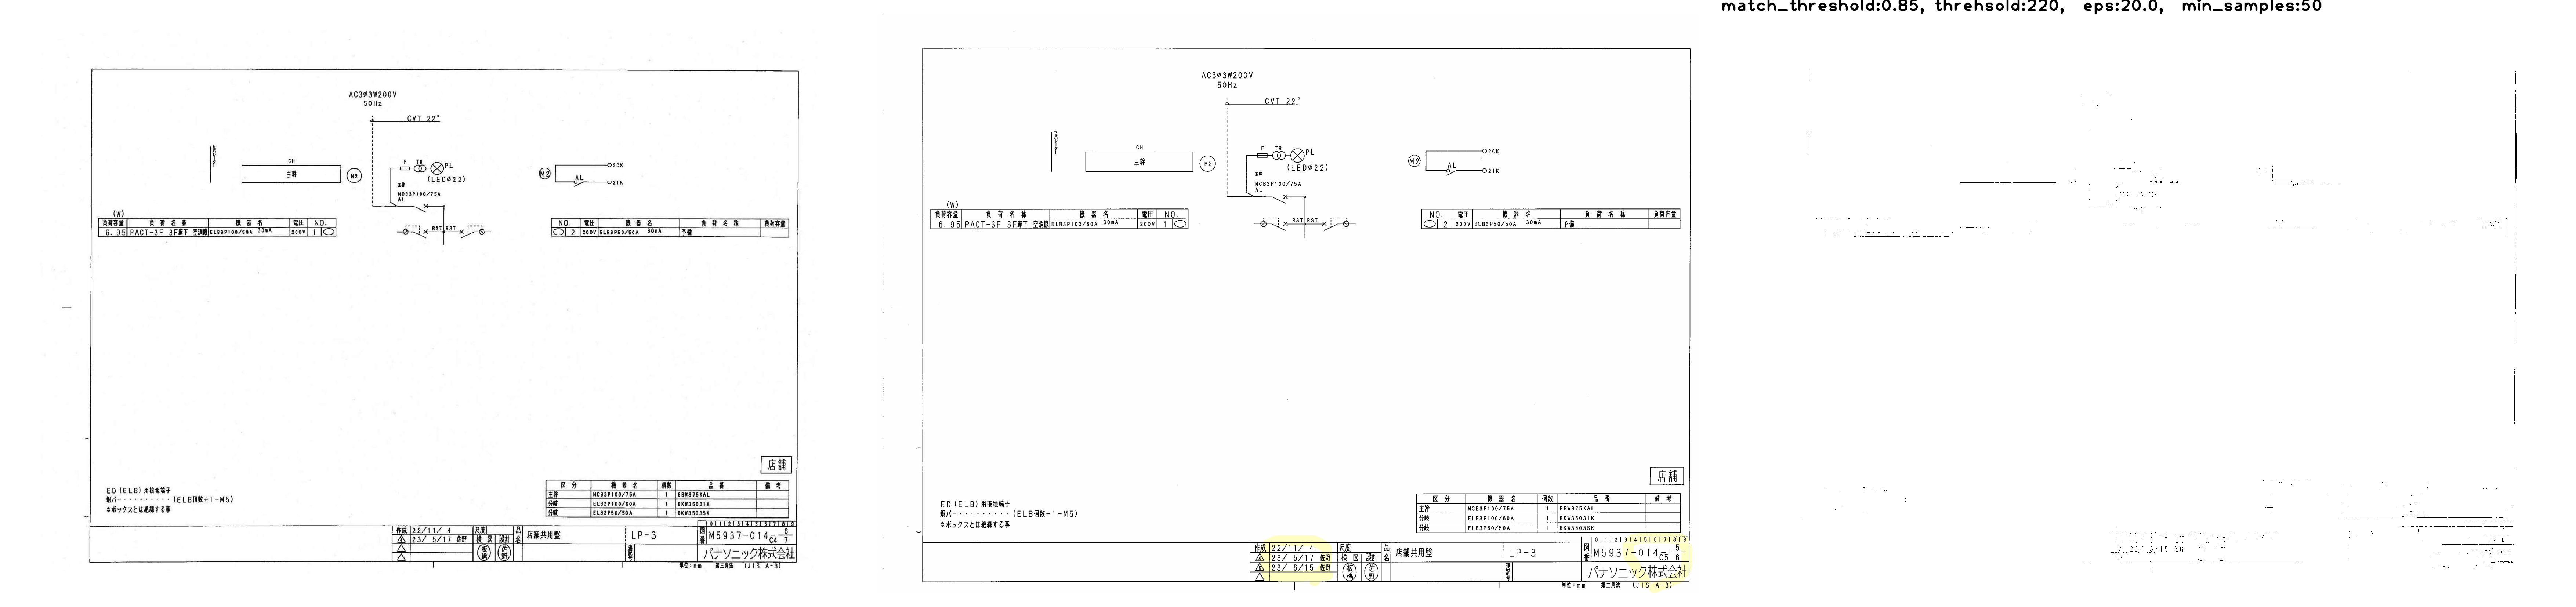

In [59]:
if __name__ == '__main__':
    main(payload=payload)